# Data Mining Project 2

https://datacatalog.cookcountyil.gov/Property-Taxation/Assessor-Archived-05-11-2022-Residential-Sales-Dat/5pge-nu6u/about_data

1. Data Acquisition

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [29]:
# or mini2/cook_county_train_val.csv
df = pd.read_csv("cook_county_train_val.csv")

In [30]:
print(len(df))

204792


In [31]:
print(df.head())

   Unnamed: 0             PIN  Property Class  Neighborhood Code  \
0           0  17294100610000             203                 50   
1           1  13272240180000             202                120   
2           2  25221150230000             202                210   
3           3  10251130030000             203                220   
4           4  31361040550000             202                120   

   Land Square Feet  Town Code  Apartments  Wall Material  Roof Material  \
0            2500.0         76         0.0            2.0            1.0   
1            3780.0         71         0.0            2.0            1.0   
2            4375.0         70         0.0            2.0            1.0   
3            4375.0         17         0.0            3.0            1.0   
4            8400.0         32         0.0            3.0            1.0   

   Basement  Basement Finish  Central Heating  Other Heating  Central Air  \
0       1.0              3.0              1.0            

2. Data Cleaning

In [32]:
# no missing values
count = df.count()
print(count)

Unnamed: 0                    204792
PIN                           204792
Property Class                204792
Neighborhood Code             204792
Land Square Feet              204792
Town Code                     204792
Apartments                    204792
Wall Material                 204792
Roof Material                 204792
Basement                      204792
Basement Finish               204792
Central Heating               204792
Other Heating                 204792
Central Air                   204792
Fireplaces                    204792
Attic Type                    204792
Attic Finish                  204792
Design Plan                   204792
Cathedral Ceiling             204792
Construction Quality          204792
Site Desirability             204792
Garage 1 Size                 204792
Garage 1 Material             204792
Garage 1 Attachment           204792
Garage 1 Area                 204792
Garage 2 Size                 204792
Garage 2 Material             204792
G

In [33]:
# clean out sale prices equal to 1 or 0
print(len(df[df['Sale Price'] < 2]))
df = df[df['Sale Price'] > 1]

35546


In [34]:
# drop non numeric columns
# could drop Property Class, Town Code, Neighborhood code, Census Tract, Town and Neighborhood
df = df.drop(columns=['PIN', 'Deed No.', 'Modeling Group', 'Description'])

In [35]:
# drop empty / mostly empty columns
# could drop "Multi Property Indicator" as well
df = df.drop(columns=['Apartments', 'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area', 'Number of Commercial Units', 'Use'])

In [36]:
# remove outliers with Isolation Forest
from sklearn.ensemble import IsolationForest
iso = IsolationForest(contamination=0.05)
yhat = iso.fit_predict(df[['Sale Price']])
mask = yhat != -1
df = df[mask]

2. Hypotheses

1. The square footage of a building is positively correlated with the sale price of the building.
2. Simple linear regression will not be able to accurately predict the sale price of a building.
3. Polynomial regression will be the best model for predicting the sale price of a building.

3. Data Visualization

In [37]:
def scatter_plot_x_y(x,y):
    print(f"\'{x}\' vs \'{y}\'")
    plt.scatter(np.log(df[x]), np.log(df[y]))
    plt.show()

'Building Square Feet' vs 'Sale Price'


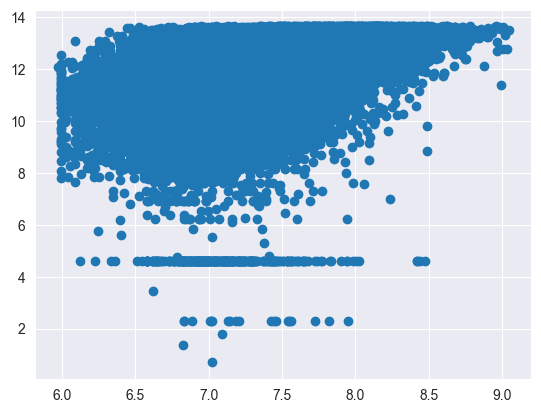

'Lot Size' vs 'Sale Price'


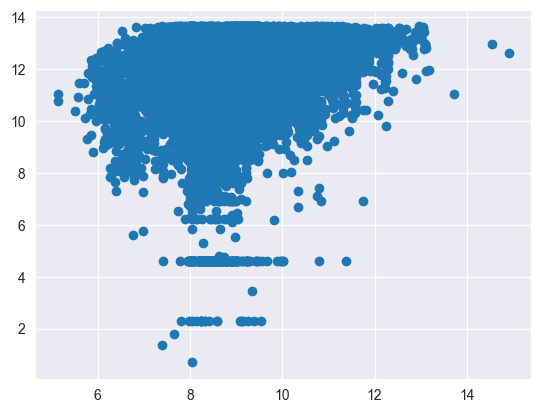

'Estimate (Land)' vs 'Sale Price'


/Users/turnerburchard/Documents/School/data-mining-550/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


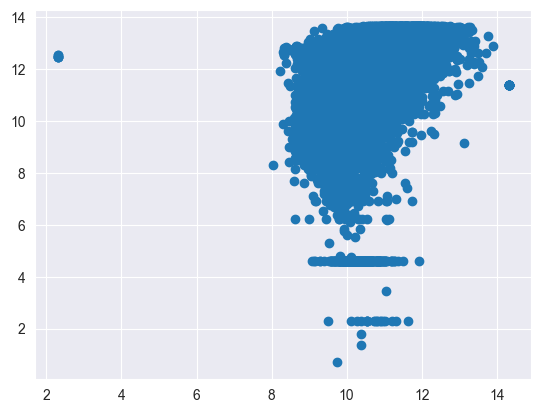

'Estimate (Building)' vs 'Sale Price'


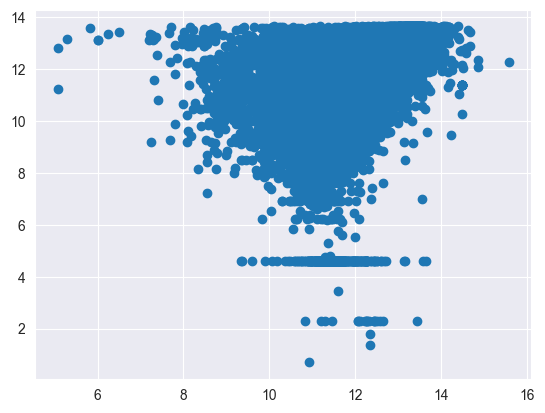

'Age' vs 'Sale Price'


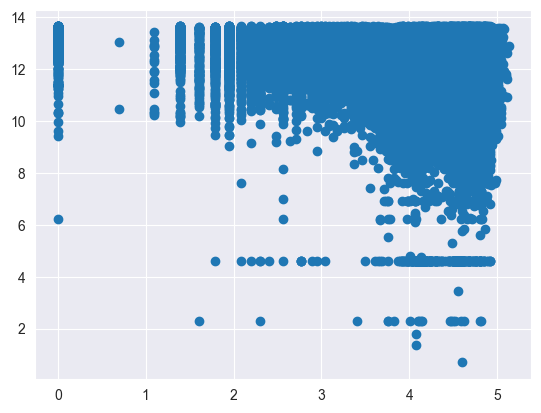

In [38]:
for var in ['Building Square Feet','Lot Size','Estimate (Land)','Estimate (Building)','Age']:
    scatter_plot_x_y(var, 'Sale Price')

5. Model Development

In [39]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV, LinearRegression
from scipy.interpolate import CubicSpline

In [40]:
# 5-fold Cross Validation
def cross_validate(model, X, y, n_folds=5):
    scores = cross_val_score(model, X, y, cv=n_folds, scoring='neg_mean_squared_error')
    return int(np.sqrt((-np.mean(scores)))) # return RMSE

In [41]:
# Simple Regression
def simple_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model

model = simple_regression(df[['Estimate (Land)']], df['Sale Price'])

print("Simple Regression Error: ")
print(cross_validate(model, df[['Estimate (Land)']], df['Sale Price']))

Simple Regression Error: 
148412


In [42]:
# Multiple Regression with all features
def multiple_regression(X, y):
    model = LinearRegression()
    model.fit(X, y)
    return model


multiple_model = multiple_regression(df.drop(columns=['Sale Price']), df['Sale Price'])

print("Multiple Regression Error: ")
print(cross_validate(multiple_model, df.drop(columns=['Sale Price']), df['Sale Price']))


Multiple Regression Error: 
93824


In [43]:
# Subset Selection
def subset_selection(X, y, k):
    selector = SelectKBest(score_func=f_regression, k=k)
    return selector.fit_transform(X, y)


# Multiple Regression with subset of features
k = 15 # Best from tuning
X = subset_selection(df.drop(columns=['Sale Price']), df['Sale Price'], k)
subset_model = multiple_regression(X, df['Sale Price'])

print("Subset Regression Error: ")
print(cross_validate(subset_model, X, df['Sale Price']))

Subset Regression Error: 
98686


In [44]:
# Regularization
def pca(X, y, k):
    model = PCA(n_components=k)
    model = model.fit_transform(X, y)

    return model

k = 15 # Best from tuning
X = pca(df.drop(columns=['Sale Price']), df['Sale Price'], k)
pca_model = multiple_regression(X, df['Sale Price'])

print("PCA Regression Error: ")
print(cross_validate(pca_model, X, df['Sale Price']))

PCA Regression Error: 
104568


In [45]:
# Polynomial regression
# Since this ends up being the simplest model with good results, 
# we conclude that this is the best model for the dataset

def polynomial_regression(X, y, degree):
    print("Fitting polynomial regression model with degree:", degree)
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)
    model = LinearRegression()
    model.fit(X_poly, y)
    return model


X = df.drop(columns=['Sale Price'])
y = df['Sale Price']
degree = 1  # Best from tuning - basically a linear model
poly_model = polynomial_regression(X, y, degree)

print("Polynomial Regression Error: ")
print(cross_validate(poly_model, X, y))

Fitting polynomial regression model with degree: 1
Polynomial Regression Error: 
93824


In [46]:
# Cubic Spline
# This has issues due to extreme overfitting, 
# we do not believe this to be a useful model for the dataset

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import SplineTransformer

def spline_regressor():
    return make_pipeline(SplineTransformer(degree=3, n_knots=10), LinearRegression())

X = df.drop(columns=['Sale Price'])
y = df['Sale Price']

print("Spline Regression Error: ")
print(np.sqrt(cross_validate(spline_regressor(), X, y)))


Spline Regression Error: 
23181943.125185903


In [47]:
# Lasso Regularization
def lassocv_regularization(X, y):
    lasso_cv = LassoCV(cv=5).fit(X, y)
    return lasso_cv

X = df.drop(columns=['Sale Price'])
y = df['Sale Price']

lasscv_model = lassocv_regularization(X, y)

print("Lasso Regression Error: ")
print(cross_validate(lasscv_model, X, y))

Lasso Regression Error: 
109439


In [48]:
# Ridge Regularization
def ridgecv_regularization(X, y):
    ridgecv_model = RidgeCV(cv=5).fit(X, y)
    return ridgecv_model

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df.drop(columns=['Sale Price']))
y = df['Sale Price']

ridgecv_model = ridgecv_regularization(X_scaled, y)

print("Ridge Regression Error: ")
print(cross_validate(ridgecv_model, X_scaled, y))

Ridge Regression Error: 
93824
